<a href="https://colab.research.google.com/github/RohitKumar23-11/Transfer-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFLow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [ ]:
# Are we using a GPU?
!nvidia-smi

Thu Jul  6 04:38:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Downloading and becoming one with data

In [ ]:
# Get the data (10% of 10 food classes from Food101) - https://www.kaggle.com/dansbecker/food-101
import zipfile

# Downloadn the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-07-06 04:41:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   120MB/s    in 1.3s    

2023-07-06 04:41:34 (120 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Creating data loader (preparing the data)
we'll use the `ImageDataGenerator` class to load in our images in batches.

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training (before it rains too long and overfits) with the EarlyStopping callback

In [ ]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

> 🔑**Note:** You can customize the directory where your TensorBoard log (model training metrics) get saved to whatever you like. The `log_dir` parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
# Let's compare the following two models

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [ ]:
# Import dependencies

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Let's make a create_model function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensforFLow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str) : A TensorFlow Hub features extraction URL.
    num_classes (int) : Number of output neurons in the output layer, should
    be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as features extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save i as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # Freeze the already learned patterns
                                          name = "feature_extraction_layer",
                                          input_shape=IMAGE_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax",name="output_layer")
  ])

  return model

# Creating and Testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                           num_classes=train_data_10_percent.num_classes)

In [ ]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Let's Fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                            epochs=5,
                            steps_per_epoch=len(train_data_10_percent),
                            validation_data=test_data,
                             validation_steps=len(test_data),
                            callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                    experiment_name="resnet50V2")]
                            )

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20230706-060759
Epoch 1/5
24/24 [==============================] - 20s 818ms/step - loss: 0.3078 - accuracy: 0.9373 - val_loss: 0.6341 - val_accuracy: 0.7848
Epoch 2/5
24/24 [==============================] - 20s 871ms/step - loss: 0.2605 - accuracy: 0.9573 - val_loss: 0.6264 - val_accuracy: 0.7896
Epoch 3/5
24/24 [==============================] - 18s 759ms/step - loss: 0.2203 - accuracy: 0.9707 - val_loss: 0.6112 - val_accuracy: 0.7944
Epoch 4/5
24/24 [==============================] - 19s 800ms/step - loss: 0.1896 - accuracy: 0.9813 - val_loss: 0.6258 - val_accuracy: 0.7868
Epoch 5/5
24/24 [==============================] - 18s 780ms/step - loss: 0.1636 - accuracy: 0.9840 - val_loss: 0.6076 - val_accuracy: 0.7904


Wow!

That. Is. Incredible. Our transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

In [ ]:
# Let's create a function to plot the loss curves...
# Tidbit: you could put a function like this into a script called "helper.py" and import it
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()


  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

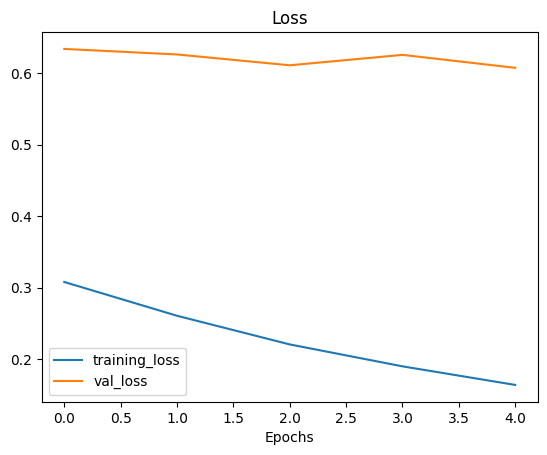

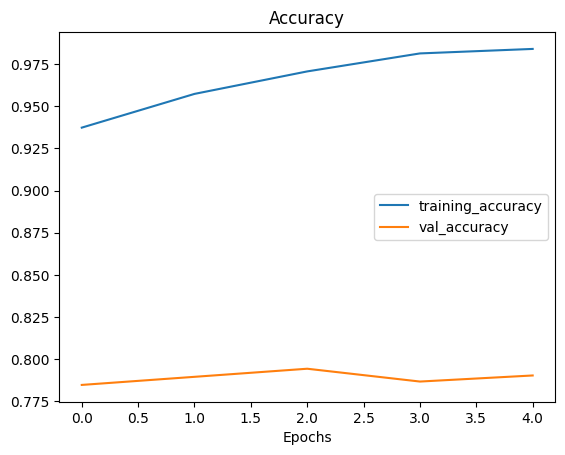

In [ ]:
plot_loss_curves(resnet_history)

# Creating and Testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [ ]:
# Create efficientNetB0 feature extractor model -- details on efficientnet: https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20230706-062646
Epoch 1/5
24/24 [==============================] - 37s 1s/step - loss: 1.7834 - accuracy: 0.4707 - val_loss: 1.2587 - val_accuracy: 0.7280
Epoch 2/5
24/24 [==============================] - 26s 1s/step - loss: 1.0316 - accuracy: 0.7773 - val_loss: 0.8501 - val_accuracy: 0.8296
Epoch 3/5
24/24 [==============================] - 25s 1s/step - loss: 0.7421 - accuracy: 0.8400 - val_loss: 0.6865 - val_accuracy: 0.8496
Epoch 4/5
24/24 [==============================] - 24s 1s/step - loss: 0.5938 - accuracy: 0.8787 - val_loss: 0.6064 - val_accuracy: 0.8568
Epoch 5/5
24/24 [==============================] - 18s 762ms/step - loss: 0.5059 - accuracy: 0.8947 - val_loss: 0.5509 - val_accuracy: 0.8636


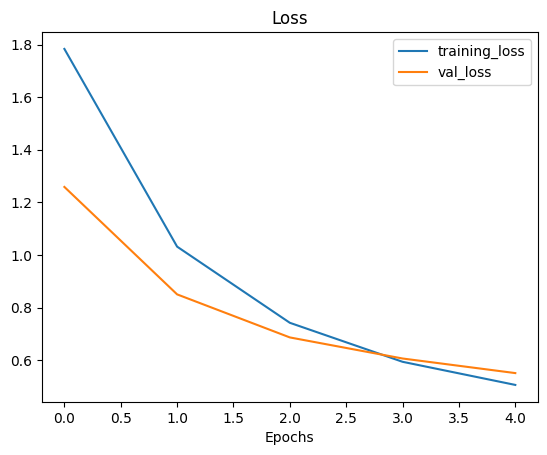

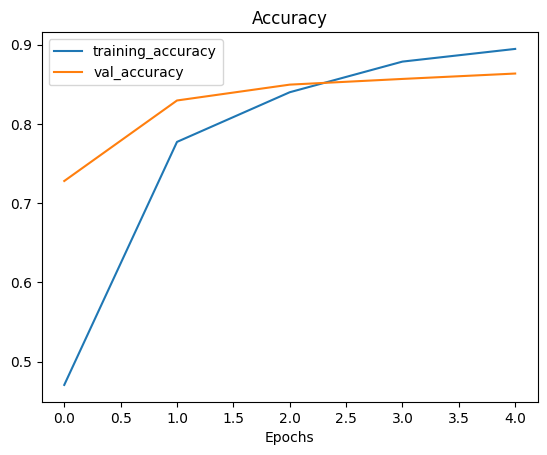

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# How many layers does our efficientnetb0 features extractor have?
len(efficientnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is"** transfer learning - using an existing model with no changes what so ever (e.g., using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (e.g., EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning"** transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

> 🔑**Note:** When you upload to TensorBoard.dev, you experiments are public. So, if you're running private experiments (things you don't want others to see) do not upload them to TensorFlowBoard.dev

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


Our TensorBoard experiments are uploaded publically here: https://tensorboard.dev/experiment/G3nPEaRMR5mE0DZJYkx8zQ/

In [ ]:
# Check out what TensorBoard experiments you have
! tensorboard dev list

In [ ]:
# Delete an exeriment
# !tensorboard dev delete --experiment_id G3nPEaRMR5mE0DZJYkx8zQ

In [ ]:
# Confirm the deletion by re-checking what experiments you have left
#!tensorboard dev list